In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

In [ ]:
!pip install Unidecode
from unidecode import unidecode

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Data Cleaning

In [ ]:
divar_df = pd.read_csv('Houses.csv')
divar_df_copy = divar_df.copy()
print(divar_df.shape)
divar_df.isnull().sum()

(201037, 20)


area                             0
latitude                    172088
longitude                   172088
price                        50413
متراژ                            2
ساخت                             6
اتاق                             4
قیمت کل                          0
قیمت هر متر                  50415
طبقه                             7
آسانسور                     129513
پارکینگ                     125513
انباری                      118320
تعداد واحد در طبقه          129568
سند                         130689
بالکن ندارد                 194778
جنس کف سرامیک               164956
سرویس بهداشتی ایرانی        186896
سرمایش کولر آبی             164442
تأمین‌کننده آب گرم پکیج    167163
dtype: int64

In [ ]:
divar_df_copy.dropna(subset=['price'] , inplace = True)
divar_df_copy.drop(divar_df_copy.iloc[ : , -6:] , axis = 1 , inplace = True)

In [ ]:
divar_df_copy.drop(['قیمت کل'  , 'latitude' , 'longitude'] , axis=1 , inplace = True)
new_columns = ['district' , 'price', 'area' , 'age_of_building' ,'room' , 'price_per_meter' , 'floor' , 'elevator' , 'parking' , 'basement' , 'n_house_in_floor']
divar_df_copy.columns = new_columns

In [ ]:
def numeric_converter(column):
    list_elm = [i for i in column]
    English_list_elm = []
    for i in range(len(list_elm)):
        English_list_elm.append(unidecode(f'{list_elm[i]}'))
    column = English_list_elm
    return pd.to_numeric(column , errors='coerce')

In [ ]:
divar_df_copy['room'].replace(['بدون اتاق', '+۴'] , [0 , 5] , inplace=True)
divar_df_copy['age_of_building'].replace(['قبل از ۱۳۷۰'] , ['1370'] , inplace=True)

In [ ]:
divar_df_copy['area'] = numeric_converter(divar_df_copy['area'])
divar_df_copy['room'] = numeric_converter(divar_df_copy['room'])
divar_df_copy['age_of_building'] = numeric_converter(divar_df_copy['age_of_building'])

In [ ]:
divar_df_copy['price_per_meter'] = divar_df_copy['price'] / divar_df_copy['area']
divar_df_copy['age_of_building'] = 1401 - divar_df_copy['age_of_building']

In [ ]:
divar_df_copy[divar_df_copy['price'] == 480000000000]
divar_df_copy.drop(16658  , inplace = True)

In [ ]:
divar_df_copy['n_house_in_floor'].replace(['بیشتر از ۸'] , [9] , inplace=True)
divar_df_copy['n_house_in_floor'] = numeric_converter(divar_df_copy['n_house_in_floor'])

In [ ]:
floor_list=[str(i).split()for i in divar_df_copy['floor']]
for floor in floor_list:
    if len(floor) != 1:
        floor.remove('از')
    else:
        floor.append(np.nan)

In [ ]:
for floor in floor_list:
    if 'همکف' in floor:
        floor[floor.index('همکف')] = 0
    if 'زیرهمکف' in floor:
        floor[floor.index('زیرهمکف')] = -1

In [ ]:
for floor_index in range(len(floor_list)):
    floor_list[floor_index][0] = unidecode(f'{floor_list[floor_index][0]}')
    if floor_list[floor_index][1] != np.nan:
        floor_list[floor_index][1] = unidecode(f'{floor_list[floor_index][1]}')

In [ ]:
single_floor = []
total_floor = []
for floor in floor_list:
    single_floor.append(floor[0])
    total_floor.append(floor[1])
divar_df_copy['total_floor'] = total_floor
divar_df_copy['floor'] = single_floor

In [ ]:
divar_df_copy['total_floor'] = pd.to_numeric(divar_df_copy['total_floor'] , errors='coerce')
divar_df_copy['floor'] = pd.to_numeric(divar_df_copy['floor'] , errors='coerce')

In [ ]:
divar_df_copy[['elevator' , 'parking' , 'basement']] =divar_df_copy[['elevator' , 'parking' , 'basement']].replace([True  , 'true' , np.nan] , [1 ,1 , 0])

In [ ]:
group_district = divar_df_copy['price_per_meter'].groupby(divar_df_copy['district']).mean()
for district , mean_price in group_district.items():
    divar_df_copy['district'].replace(district , mean_price , inplace=True)

In [ ]:
divar_df_copy.dropna(subset=['floor'] , inplace = True)

In [ ]:
divar_df_copy.drop(['total_floor' , 'n_house_in_floor'] , axis=1 , inplace = True)

In [ ]:
def detect_outlier(district , column):
    rows = divar_df_copy[divar_df_copy['district'] == district]
    column_values = rows[column]
    q1 = column_values.quantile(0.25)
    q3 = column_values.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - (1.5 * iqr)
    high_outlier = q3 + (1.5 * iqr)
    lower = rows[rows[column] < low_outlier]
    higher = rows[rows[column] > high_outlier]
    divar_df_copy.drop(lower.index , inplace = True , axis = 0)
    divar_df_copy.drop(higher.index , inplace = True , axis = 0)

columns = ['area' , 'price_per_meter']
districts = divar_df_copy['district'].unique()
for dis in districts:
    for col in columns:
        detect_outlier(dis , col)

In [ ]:
print(divar_df_copy.shape)
divar_df_copy

(140569, 10)


,district,price,area,age_of_building,room,price_per_meter,floor,elevator,parking,basement
0,2.443390e+07,9.600000e+08,54.0,5.0,2.0,1.777778e+07,1.0,1,1,1
1,2.443390e+07,2.100000e+09,63.0,8.0,2.0,3.333333e+07,3.0,1,1,1
3,2.957418e+07,1.060000e+09,38.0,21.0,1.0,2.789474e+07,3.0,0,0,1
5,6.815265e+07,7.100000e+09,120.0,16.0,2.0,5.916667e+07,4.0,0,0,0
6,2.443390e+07,1.650000e+09,68.0,15.0,2.0,2.426471e+07,5.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
201031,4.348155e+07,5.600000e+09,130.0,1.0,3.0,4.307692e+07,4.0,1,1,1
201032,4.348155e+07,3.700000e+09,74.0,11.0,2.0,5.000000e+07,3.0,0,0,0
201033,4.348155e+07,7.500000e+09,130.0,9.0,3.0,5.769231e+07,1.0,1,1,1
201035,4.348155e+07,3.690000e+09,75.0,14.0,2.0,4.920000e+07,1.0,0,0,0


In [ ]:
_deepnote_run_altair(divar_df_copy, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"area","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"n_house_in_floor","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

### Prediction

In [ ]:
x_train , x_test , y_train , y_test = model_selection.train_test_split(divar_df_copy.loc[ : , divar_df_copy.columns != 'price'] , divar_df_copy.iloc[ : , 1] , test_size=0.3)

2.2905277409285327e+18


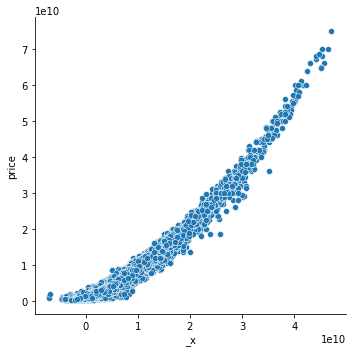

In [ ]:
lr = LinearRegression()
lr.fit(x_train , y_train)
predict_lr = lr.predict(x_test)
MSE_lr = metrics.mean_squared_error(y_test , predict_lr)
print(MSE_lr)
sns.relplot(x=predict_lr , y= y_test)

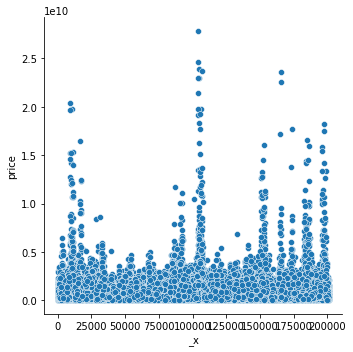

In [ ]:
differnce = abs(predict_lr - y_test)
sns.relplot(x= differnce.index , y=differnce)

In [ ]:
from sklearn.model_selection import cross_val_score as cvs
accuracy_lr_train = cvs(LinearRegression(), x_train, y_train, scoring='r2', cv=10)
accuracy_lr_test = cvs(LinearRegression(), x_test, y_test, scoring='r2', cv=10)
print(accuracy_lr_train.mean())
print(accuracy_lr_test.mean())

0.9324665094907358
0.9328512376212961


0.9329041682149732

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3e9f5ad7-0862-48dc-b4f2-2368993d88c8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>